# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-76b7a0e0-ff40-a24b-2d26-e28a8ed68ab4)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:05<00:00, 30012004.92it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset) / 2
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:04<00:00,  8.85it/s]


Epoch  1: Loss = 2.1317 Acc = 0.26 Test_Loss = 1.7488 Test_Acc = 0.36


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch  2: Loss = 1.7499 Acc = 0.38 Test_Loss = 1.6380 Test_Acc = 0.40


100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


Epoch  3: Loss = 1.7704 Acc = 0.39 Test_Loss = 1.4860 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch  4: Loss = 1.5871 Acc = 0.44 Test_Loss = 1.3973 Test_Acc = 0.49


100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Epoch  5: Loss = 1.5203 Acc = 0.47 Test_Loss = 1.3227 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch  6: Loss = 1.4930 Acc = 0.48 Test_Loss = 1.2897 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch  7: Loss = 1.3830 Acc = 0.51 Test_Loss = 1.3162 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch  8: Loss = 1.3508 Acc = 0.52 Test_Loss = 1.4092 Test_Acc = 0.54


100%|██████████| 40/40 [00:04<00:00,  8.81it/s]


Epoch  9: Loss = 1.4063 Acc = 0.51 Test_Loss = 1.3175 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


Epoch 10: Loss = 1.2606 Acc = 0.55 Test_Loss = 4.7602 Test_Acc = 0.52


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 11: Loss = 1.4192 Acc = 0.50 Test_Loss = 1.2302 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 12: Loss = 1.3193 Acc = 0.55 Test_Loss = 1.2663 Test_Acc = 0.54


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 13: Loss = 1.2923 Acc = 0.55 Test_Loss = 1.2106 Test_Acc = 0.58


100%|██████████| 40/40 [00:04<00:00,  9.69it/s]


Epoch 14: Loss = 1.2120 Acc = 0.58 Test_Loss = 1.1432 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 15: Loss = 1.1318 Acc = 0.61 Test_Loss = 1.0787 Test_Acc = 0.63


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 16: Loss = 1.3779 Acc = 0.52 Test_Loss = 11.7084 Test_Acc = 0.46


100%|██████████| 40/40 [00:03<00:00, 10.38it/s]


Epoch 17: Loss = 1.5837 Acc = 0.46 Test_Loss = 2.1214 Test_Acc = 0.44


100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


Epoch 18: Loss = 1.3306 Acc = 0.54 Test_Loss = 1.2631 Test_Acc = 0.58


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 19: Loss = 1.5338 Acc = 0.47 Test_Loss = 4.9087 Test_Acc = 0.34


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 20: Loss = 1.6375 Acc = 0.43 Test_Loss = 1.5712 Test_Acc = 0.43


100%|██████████| 40/40 [00:03<00:00, 10.59it/s]


Epoch 21: Loss = 1.5224 Acc = 0.47 Test_Loss = 1.6355 Test_Acc = 0.43


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 22: Loss = 1.5148 Acc = 0.47 Test_Loss = 1.5386 Test_Acc = 0.53


100%|██████████| 40/40 [00:03<00:00, 11.93it/s]


Epoch 23: Loss = 1.3746 Acc = 0.51 Test_Loss = 1.2037 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 24: Loss = 1.2311 Acc = 0.56 Test_Loss = 1.1321 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 25: Loss = 1.2385 Acc = 0.57 Test_Loss = 1.6446 Test_Acc = 0.55


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 26: Loss = 1.1990 Acc = 0.58 Test_Loss = 1.1147 Test_Acc = 0.60


100%|██████████| 40/40 [00:03<00:00, 11.94it/s]


Epoch 27: Loss = 1.1516 Acc = 0.59 Test_Loss = 1.3754 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 28: Loss = 1.1008 Acc = 0.61 Test_Loss = 1.1901 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 29: Loss = 1.0741 Acc = 0.62 Test_Loss = 1.1076 Test_Acc = 0.61


100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 30: Loss = 1.1400 Acc = 0.60 Test_Loss = 1.3965 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.47it/s]


Epoch 31: Loss = 1.3202 Acc = 0.55 Test_Loss = 1.1244 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 32: Loss = 1.0972 Acc = 0.61 Test_Loss = 1.0163 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.19it/s]


Epoch 33: Loss = 1.1040 Acc = 0.62 Test_Loss = 2.6708 Test_Acc = 0.45


100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Epoch 34: Loss = 1.3331 Acc = 0.54 Test_Loss = 1.1334 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 35: Loss = 1.1212 Acc = 0.62 Test_Loss = 0.9945 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 36: Loss = 1.0035 Acc = 0.65 Test_Loss = 0.9285 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 37: Loss = 0.9854 Acc = 0.66 Test_Loss = 0.9491 Test_Acc = 0.66


100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


Epoch 38: Loss = 1.3197 Acc = 0.56 Test_Loss = 1.1008 Test_Acc = 0.61


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 39: Loss = 1.1465 Acc = 0.61 Test_Loss = 0.9540 Test_Acc = 0.66


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 40: Loss = 1.2477 Acc = 0.58 Test_Loss = 1.5557 Test_Acc = 0.59


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 41: Loss = 1.1998 Acc = 0.60 Test_Loss = 18.3308 Test_Acc = 0.33


100%|██████████| 40/40 [00:04<00:00,  9.16it/s]


Epoch 42: Loss = 1.4279 Acc = 0.50 Test_Loss = 1.4092 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 12.08it/s]


Epoch 43: Loss = 1.3934 Acc = 0.53 Test_Loss = 6.5601 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 44: Loss = 1.4947 Acc = 0.48 Test_Loss = 1.2179 Test_Acc = 0.55


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


Epoch 45: Loss = 1.2655 Acc = 0.55 Test_Loss = 1.1837 Test_Acc = 0.57


100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


Epoch 46: Loss = 1.1400 Acc = 0.60 Test_Loss = 1.1915 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Epoch 47: Loss = 1.1477 Acc = 0.60 Test_Loss = 1.0622 Test_Acc = 0.64


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 48: Loss = 1.0889 Acc = 0.62 Test_Loss = 1.2235 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 49: Loss = 0.9996 Acc = 0.65 Test_Loss = 0.9718 Test_Acc = 0.67


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 50: Loss = 1.0022 Acc = 0.65 Test_Loss = 4.7015 Test_Acc = 0.62


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 51: Loss = 0.9868 Acc = 0.66 Test_Loss = 0.9011 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 52: Loss = 0.9495 Acc = 0.66 Test_Loss = 0.8555 Test_Acc = 0.70


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


Epoch 53: Loss = 1.0761 Acc = 0.63 Test_Loss = 1.0185 Test_Acc = 0.64


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 54: Loss = 0.9738 Acc = 0.66 Test_Loss = 0.8944 Test_Acc = 0.68


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 55: Loss = 0.9898 Acc = 0.66 Test_Loss = 0.9127 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 56: Loss = 0.8867 Acc = 0.69 Test_Loss = 0.8308 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.53it/s]


Epoch 57: Loss = 0.8426 Acc = 0.70 Test_Loss = 0.8251 Test_Acc = 0.71


100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Epoch 58: Loss = 0.8336 Acc = 0.71 Test_Loss = 0.8425 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 59: Loss = 0.8000 Acc = 0.72 Test_Loss = 0.7642 Test_Acc = 0.73


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 60: Loss = 0.7780 Acc = 0.72 Test_Loss = 0.7539 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 61: Loss = 0.7442 Acc = 0.74 Test_Loss = 0.7533 Test_Acc = 0.74


100%|██████████| 40/40 [00:04<00:00,  8.88it/s]


Epoch 62: Loss = 0.7257 Acc = 0.75 Test_Loss = 0.7235 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Epoch 63: Loss = 0.7356 Acc = 0.74 Test_Loss = 0.7377 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 64: Loss = 0.7281 Acc = 0.74 Test_Loss = 0.7222 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 65: Loss = 0.6896 Acc = 0.76 Test_Loss = 0.6951 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch 66: Loss = 0.6829 Acc = 0.76 Test_Loss = 0.7222 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 67: Loss = 0.6674 Acc = 0.76 Test_Loss = 0.7097 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Epoch 68: Loss = 0.6464 Acc = 0.77 Test_Loss = 0.7103 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


Epoch 69: Loss = 0.6395 Acc = 0.78 Test_Loss = 0.6822 Test_Acc = 0.76


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 70: Loss = 0.6327 Acc = 0.78 Test_Loss = 0.6666 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 71: Loss = 0.6188 Acc = 0.78 Test_Loss = 0.6783 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 72: Loss = 0.6104 Acc = 0.78 Test_Loss = 0.6608 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 73: Loss = 0.6128 Acc = 0.79 Test_Loss = 0.6898 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 74: Loss = 0.5930 Acc = 0.79 Test_Loss = 0.6713 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 75: Loss = 0.5838 Acc = 0.79 Test_Loss = 0.6613 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


Epoch 76: Loss = 0.5787 Acc = 0.80 Test_Loss = 0.6619 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 77: Loss = 0.5731 Acc = 0.80 Test_Loss = 0.6429 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 78: Loss = 0.5649 Acc = 0.80 Test_Loss = 1.1203 Test_Acc = 0.69


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 79: Loss = 1.4421 Acc = 0.51 Test_Loss = 4.8434 Test_Acc = 0.50


100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 80: Loss = 1.1886 Acc = 0.59 Test_Loss = 1.1846 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 81: Loss = 0.9478 Acc = 0.68 Test_Loss = 0.8279 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 82: Loss = 0.9125 Acc = 0.70 Test_Loss = 2.5643 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.67it/s]


Epoch 83: Loss = 0.9118 Acc = 0.69 Test_Loss = 1.1947 Test_Acc = 0.59


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 84: Loss = 0.8836 Acc = 0.69 Test_Loss = 0.8133 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 85: Loss = 0.7432 Acc = 0.73 Test_Loss = 0.7337 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 86: Loss = 0.6839 Acc = 0.76 Test_Loss = 0.7066 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 87: Loss = 0.6447 Acc = 0.77 Test_Loss = 0.6538 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Epoch 88: Loss = 0.6183 Acc = 0.78 Test_Loss = 0.6803 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 89: Loss = 0.5966 Acc = 0.79 Test_Loss = 0.6451 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 90: Loss = 0.5853 Acc = 0.79 Test_Loss = 0.6325 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 91: Loss = 0.5590 Acc = 0.80 Test_Loss = 0.6625 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 92: Loss = 0.5552 Acc = 0.80 Test_Loss = 0.6194 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 93: Loss = 0.5317 Acc = 0.81 Test_Loss = 0.6351 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 94: Loss = 0.5340 Acc = 0.81 Test_Loss = 0.6094 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 95: Loss = 0.5251 Acc = 0.81 Test_Loss = 0.6143 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Epoch 96: Loss = 0.5126 Acc = 0.82 Test_Loss = 0.5922 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 97: Loss = 0.5023 Acc = 0.82 Test_Loss = 0.5957 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 98: Loss = 0.4901 Acc = 0.83 Test_Loss = 0.6011 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 99: Loss = 0.4785 Acc = 0.83 Test_Loss = 0.6015 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


Epoch 100: Loss = 0.4902 Acc = 0.83 Test_Loss = 0.5875 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 101: Loss = 0.4710 Acc = 0.83 Test_Loss = 0.5989 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 102: Loss = 0.4648 Acc = 0.84 Test_Loss = 0.5984 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 103: Loss = 0.4926 Acc = 0.83 Test_Loss = 0.6118 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 104: Loss = 0.4947 Acc = 0.83 Test_Loss = 0.6026 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Epoch 105: Loss = 0.4549 Acc = 0.84 Test_Loss = 0.5974 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 106: Loss = 0.4479 Acc = 0.84 Test_Loss = 0.5936 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 107: Loss = 0.4407 Acc = 0.84 Test_Loss = 0.5785 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 108: Loss = 0.4330 Acc = 0.85 Test_Loss = 0.5520 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


Epoch 109: Loss = 0.4285 Acc = 0.85 Test_Loss = 0.6134 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 110: Loss = 0.4374 Acc = 0.84 Test_Loss = 0.6071 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 111: Loss = 0.4083 Acc = 0.86 Test_Loss = 0.5479 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 112: Loss = 0.4109 Acc = 0.86 Test_Loss = 0.5695 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 113: Loss = 0.4027 Acc = 0.86 Test_Loss = 0.5445 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 114: Loss = 0.3924 Acc = 0.86 Test_Loss = 0.5747 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 115: Loss = 0.3903 Acc = 0.86 Test_Loss = 0.5746 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.18it/s]


Epoch 116: Loss = 0.3936 Acc = 0.86 Test_Loss = 0.5469 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.90it/s]


Epoch 117: Loss = 0.3850 Acc = 0.86 Test_Loss = 0.5666 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 118: Loss = 0.3759 Acc = 0.87 Test_Loss = 0.5821 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 119: Loss = 0.3770 Acc = 0.87 Test_Loss = 0.5835 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 120: Loss = 0.3719 Acc = 0.87 Test_Loss = 0.5650 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 121: Loss = 0.3648 Acc = 0.87 Test_Loss = 0.5654 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 122: Loss = 0.3625 Acc = 0.87 Test_Loss = 0.5533 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 123: Loss = 0.3548 Acc = 0.87 Test_Loss = 0.5447 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.28it/s]


Epoch 124: Loss = 0.3420 Acc = 0.88 Test_Loss = 0.5502 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 125: Loss = 0.3472 Acc = 0.88 Test_Loss = 0.5465 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 126: Loss = 0.3369 Acc = 0.88 Test_Loss = 0.5553 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 127: Loss = 0.3354 Acc = 0.88 Test_Loss = 0.5643 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 128: Loss = 0.3369 Acc = 0.88 Test_Loss = 0.6011 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Epoch 129: Loss = 0.3276 Acc = 0.89 Test_Loss = 0.5460 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.86it/s]


Epoch 130: Loss = 0.3189 Acc = 0.89 Test_Loss = 0.5563 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 131: Loss = 0.3237 Acc = 0.89 Test_Loss = 0.5526 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 132: Loss = 0.3230 Acc = 0.89 Test_Loss = 0.5869 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 133: Loss = 0.3388 Acc = 0.88 Test_Loss = 0.5568 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 134: Loss = 0.3547 Acc = 0.88 Test_Loss = 1.5243 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 135: Loss = 0.3975 Acc = 0.86 Test_Loss = 0.5722 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 136: Loss = 0.3165 Acc = 0.89 Test_Loss = 0.5559 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


Epoch 137: Loss = 0.3106 Acc = 0.89 Test_Loss = 0.5374 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 138: Loss = 0.2975 Acc = 0.89 Test_Loss = 0.5469 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 139: Loss = 0.2905 Acc = 0.90 Test_Loss = 0.5478 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 140: Loss = 0.2843 Acc = 0.90 Test_Loss = 0.5493 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 141: Loss = 0.2826 Acc = 0.90 Test_Loss = 0.5834 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.19it/s]


Epoch 142: Loss = 0.2749 Acc = 0.90 Test_Loss = 0.5620 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 143: Loss = 0.2720 Acc = 0.90 Test_Loss = 0.5515 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.97it/s]


Epoch 144: Loss = 0.2682 Acc = 0.90 Test_Loss = 0.5563 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.22it/s]


Epoch 145: Loss = 0.2611 Acc = 0.91 Test_Loss = 0.5414 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 146: Loss = 0.2631 Acc = 0.90 Test_Loss = 0.5365 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


Epoch 147: Loss = 0.2559 Acc = 0.91 Test_Loss = 0.5760 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 148: Loss = 0.2620 Acc = 0.91 Test_Loss = 0.5181 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 149: Loss = 0.3118 Acc = 0.89 Test_Loss = 0.5668 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


Epoch 150: Loss = 0.3626 Acc = 0.87 Test_Loss = 0.6388 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


Epoch 151: Loss = 0.2993 Acc = 0.89 Test_Loss = 0.5341 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 152: Loss = 0.2631 Acc = 0.90 Test_Loss = 0.5653 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 153: Loss = 0.2520 Acc = 0.91 Test_Loss = 0.5380 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Epoch 154: Loss = 0.2459 Acc = 0.91 Test_Loss = 0.5671 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.92it/s]


Epoch 155: Loss = 0.2463 Acc = 0.91 Test_Loss = 0.5467 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 156: Loss = 0.2295 Acc = 0.92 Test_Loss = 0.5476 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.46it/s]


Epoch 157: Loss = 0.2309 Acc = 0.92 Test_Loss = 0.5678 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 158: Loss = 0.2241 Acc = 0.92 Test_Loss = 0.5527 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.05it/s]


Epoch 159: Loss = 0.2227 Acc = 0.92 Test_Loss = 0.5820 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.92it/s]


Epoch 160: Loss = 0.2246 Acc = 0.92 Test_Loss = 0.5777 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.51it/s]


Epoch 161: Loss = 0.2264 Acc = 0.92 Test_Loss = 0.5871 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 162: Loss = 0.2122 Acc = 0.93 Test_Loss = 0.5612 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 163: Loss = 0.2177 Acc = 0.92 Test_Loss = 0.5692 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 164: Loss = 0.2126 Acc = 0.92 Test_Loss = 0.5547 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 165: Loss = 0.2114 Acc = 0.92 Test_Loss = 0.5818 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Epoch 166: Loss = 0.2046 Acc = 0.93 Test_Loss = 0.5624 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 167: Loss = 0.2103 Acc = 0.92 Test_Loss = 0.6015 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 168: Loss = 0.2067 Acc = 0.93 Test_Loss = 0.5809 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 169: Loss = 0.2021 Acc = 0.93 Test_Loss = 0.5634 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


Epoch 170: Loss = 0.1935 Acc = 0.93 Test_Loss = 0.5757 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 171: Loss = 0.1980 Acc = 0.93 Test_Loss = 0.5602 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 172: Loss = 0.1894 Acc = 0.93 Test_Loss = 0.5854 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


Epoch 173: Loss = 0.1905 Acc = 0.93 Test_Loss = 0.5892 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Epoch 174: Loss = 0.1867 Acc = 0.93 Test_Loss = 0.5789 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch 175: Loss = 0.1895 Acc = 0.93 Test_Loss = 0.6253 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 176: Loss = 0.1818 Acc = 0.94 Test_Loss = 0.6166 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.52it/s]


Epoch 177: Loss = 0.1914 Acc = 0.93 Test_Loss = 0.6285 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Epoch 178: Loss = 0.1831 Acc = 0.93 Test_Loss = 0.5967 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 179: Loss = 0.1732 Acc = 0.94 Test_Loss = 0.6231 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 180: Loss = 0.1714 Acc = 0.94 Test_Loss = 0.6239 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Epoch 181: Loss = 0.1745 Acc = 0.94 Test_Loss = 0.6189 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch 182: Loss = 0.1758 Acc = 0.94 Test_Loss = 0.6013 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 183: Loss = 0.1812 Acc = 0.94 Test_Loss = 0.8551 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 184: Loss = 0.2015 Acc = 0.93 Test_Loss = 0.6226 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 185: Loss = 0.1786 Acc = 0.94 Test_Loss = 0.6337 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 186: Loss = 0.1730 Acc = 0.94 Test_Loss = 0.5853 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Epoch 187: Loss = 0.1635 Acc = 0.94 Test_Loss = 0.6191 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 188: Loss = 0.1598 Acc = 0.94 Test_Loss = 0.6298 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


Epoch 189: Loss = 0.1617 Acc = 0.94 Test_Loss = 0.6561 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 190: Loss = 0.1581 Acc = 0.94 Test_Loss = 0.6129 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 191: Loss = 0.1560 Acc = 0.94 Test_Loss = 0.6061 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 192: Loss = 0.1568 Acc = 0.94 Test_Loss = 0.6272 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


Epoch 193: Loss = 0.1560 Acc = 0.94 Test_Loss = 0.6124 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 194: Loss = 0.1504 Acc = 0.95 Test_Loss = 0.6119 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Epoch 195: Loss = 0.1500 Acc = 0.95 Test_Loss = 0.6224 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 196: Loss = 0.1429 Acc = 0.95 Test_Loss = 0.6366 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 197: Loss = 0.1457 Acc = 0.95 Test_Loss = 0.6660 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.83it/s]


Epoch 198: Loss = 0.1492 Acc = 0.95 Test_Loss = 0.6210 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 199: Loss = 0.1458 Acc = 0.95 Test_Loss = 0.6308 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]

Epoch 200: Loss = 0.4311 Acc = 0.88 Test_Loss = 2.3953 Test_Acc = 0.68


In [ ]:
print(best_acc)

0.8464


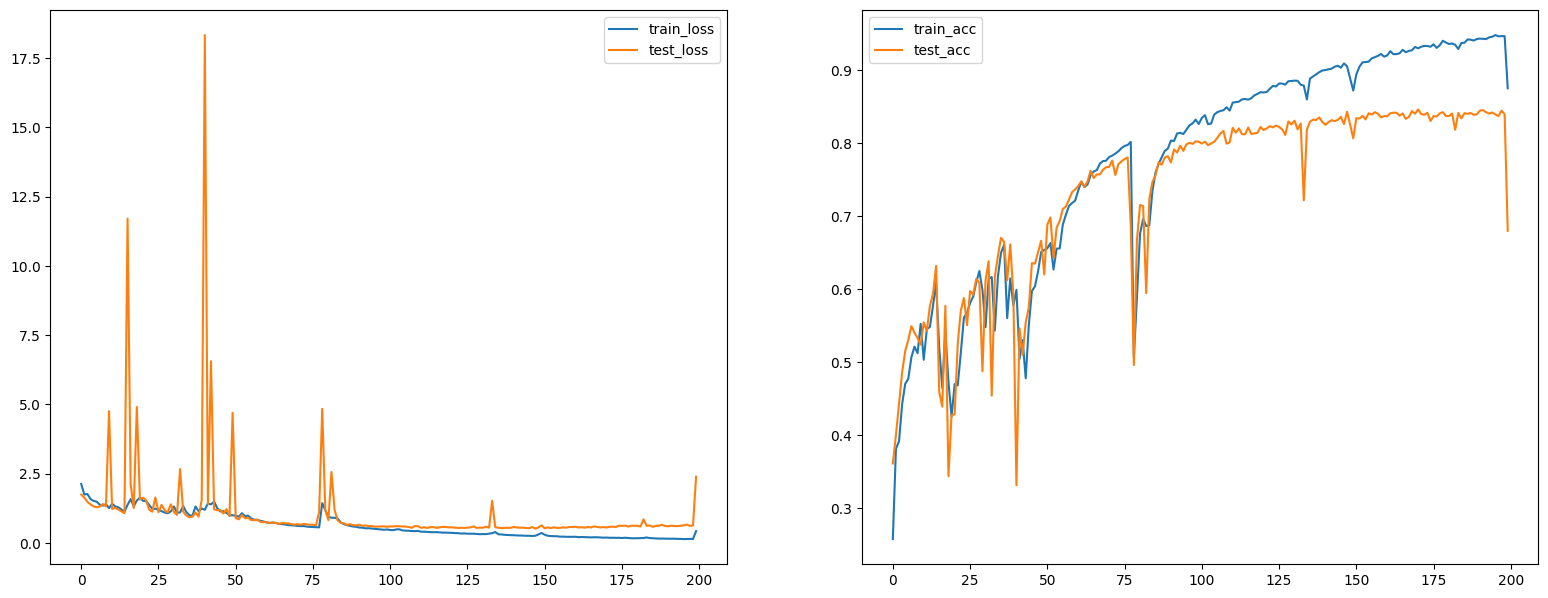

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch  1: Loss = 1.1626 Acc = 0.59 Test_Loss = 0.9140 Test_Acc = 0.69


100%|██████████| 40/40 [00:04<00:00,  9.40it/s]


Epoch  2: Loss = 0.7525 Acc = 0.74 Test_Loss = 0.7169 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 10.44it/s]


Epoch  3: Loss = 0.6566 Acc = 0.77 Test_Loss = 0.6402 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch  4: Loss = 0.6206 Acc = 0.79 Test_Loss = 0.6767 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch  5: Loss = 0.5754 Acc = 0.81 Test_Loss = 0.5901 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Epoch  6: Loss = 0.5231 Acc = 0.82 Test_Loss = 0.6458 Test_Acc = 0.79


100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


Epoch  7: Loss = 0.5686 Acc = 0.81 Test_Loss = 0.5946 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Epoch  8: Loss = 0.6029 Acc = 0.80 Test_Loss = 0.7663 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch  9: Loss = 0.5511 Acc = 0.81 Test_Loss = 0.5819 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Epoch 10: Loss = 0.4755 Acc = 0.83 Test_Loss = 0.5504 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Epoch 11: Loss = 0.4464 Acc = 0.85 Test_Loss = 0.5042 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


Epoch 12: Loss = 0.4333 Acc = 0.85 Test_Loss = 0.4795 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 13: Loss = 0.4141 Acc = 0.86 Test_Loss = 0.4675 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


Epoch 14: Loss = 0.4091 Acc = 0.86 Test_Loss = 0.5136 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Epoch 15: Loss = 0.3835 Acc = 0.87 Test_Loss = 0.5148 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 16: Loss = 0.4620 Acc = 0.85 Test_Loss = 0.8672 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 17: Loss = 0.7541 Acc = 0.75 Test_Loss = 0.8542 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 18: Loss = 0.5946 Acc = 0.79 Test_Loss = 0.5541 Test_Acc = 0.82


100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


Epoch 19: Loss = 0.4613 Acc = 0.84 Test_Loss = 0.5085 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 20: Loss = 0.4162 Acc = 0.86 Test_Loss = 0.4622 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 21: Loss = 0.3859 Acc = 0.87 Test_Loss = 0.4925 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 22: Loss = 0.3756 Acc = 0.87 Test_Loss = 0.5024 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 23: Loss = 0.3511 Acc = 0.88 Test_Loss = 0.4446 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 24: Loss = 0.3479 Acc = 0.88 Test_Loss = 0.4709 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 25: Loss = 0.3419 Acc = 0.88 Test_Loss = 0.4580 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 26: Loss = 0.3299 Acc = 0.89 Test_Loss = 0.4607 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 27: Loss = 0.3252 Acc = 0.89 Test_Loss = 0.4525 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 28: Loss = 0.3176 Acc = 0.89 Test_Loss = 0.4541 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 29: Loss = 0.3042 Acc = 0.89 Test_Loss = 0.4460 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]


Epoch 30: Loss = 0.3888 Acc = 0.87 Test_Loss = 0.4871 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 31: Loss = 0.4463 Acc = 0.85 Test_Loss = 0.4988 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 32: Loss = 0.3493 Acc = 0.88 Test_Loss = 0.4546 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 33: Loss = 0.3067 Acc = 0.89 Test_Loss = 0.4238 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 34: Loss = 0.2933 Acc = 0.90 Test_Loss = 0.4347 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.80it/s]


Epoch 35: Loss = 0.2823 Acc = 0.90 Test_Loss = 0.4292 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


Epoch 36: Loss = 0.2771 Acc = 0.90 Test_Loss = 0.4560 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 37: Loss = 0.6689 Acc = 0.80 Test_Loss = 16.1019 Test_Acc = 0.49


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 38: Loss = 1.0096 Acc = 0.67 Test_Loss = 0.6794 Test_Acc = 0.77


100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 39: Loss = 0.6109 Acc = 0.79 Test_Loss = 0.5683 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 40: Loss = 0.4853 Acc = 0.83 Test_Loss = 0.4892 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 41: Loss = 0.4143 Acc = 0.86 Test_Loss = 0.4767 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 42: Loss = 0.3712 Acc = 0.87 Test_Loss = 0.4677 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 43: Loss = 0.3357 Acc = 0.89 Test_Loss = 0.4329 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.02it/s]


Epoch 44: Loss = 0.3171 Acc = 0.89 Test_Loss = 0.4363 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


Epoch 45: Loss = 0.3015 Acc = 0.89 Test_Loss = 0.4289 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 46: Loss = 0.2823 Acc = 0.90 Test_Loss = 0.4449 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 47: Loss = 0.2839 Acc = 0.90 Test_Loss = 0.4197 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.60it/s]


Epoch 48: Loss = 0.2710 Acc = 0.91 Test_Loss = 0.4323 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 49: Loss = 0.2668 Acc = 0.91 Test_Loss = 0.4387 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 50: Loss = 0.2537 Acc = 0.91 Test_Loss = 0.4382 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.51it/s]


Epoch 51: Loss = 0.2542 Acc = 0.91 Test_Loss = 0.4272 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 52: Loss = 0.2447 Acc = 0.91 Test_Loss = 0.4417 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 53: Loss = 0.2411 Acc = 0.91 Test_Loss = 0.4653 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 54: Loss = 0.2372 Acc = 0.92 Test_Loss = 0.4330 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.67it/s]


Epoch 55: Loss = 0.2371 Acc = 0.92 Test_Loss = 0.4373 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 56: Loss = 0.2346 Acc = 0.92 Test_Loss = 0.4138 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 57: Loss = 0.2265 Acc = 0.92 Test_Loss = 0.4478 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 58: Loss = 0.2203 Acc = 0.92 Test_Loss = 0.4357 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch 59: Loss = 0.2146 Acc = 0.92 Test_Loss = 0.4294 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


Epoch 60: Loss = 0.2140 Acc = 0.92 Test_Loss = 0.4567 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 61: Loss = 0.2082 Acc = 0.93 Test_Loss = 0.4193 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.92it/s]


Epoch 62: Loss = 0.2184 Acc = 0.92 Test_Loss = 0.4178 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.85it/s]


Epoch 63: Loss = 0.2108 Acc = 0.93 Test_Loss = 0.4529 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 64: Loss = 0.2111 Acc = 0.93 Test_Loss = 0.4163 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 65: Loss = 0.2102 Acc = 0.93 Test_Loss = 0.4698 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 66: Loss = 0.3052 Acc = 0.90 Test_Loss = 1.9341 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 67: Loss = 0.4602 Acc = 0.85 Test_Loss = 0.5410 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch 68: Loss = 0.3271 Acc = 0.89 Test_Loss = 0.5820 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 69: Loss = 0.2711 Acc = 0.91 Test_Loss = 0.4029 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 70: Loss = 0.2274 Acc = 0.92 Test_Loss = 0.4209 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


Epoch 71: Loss = 0.2286 Acc = 0.92 Test_Loss = 0.4471 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


Epoch 72: Loss = 0.2132 Acc = 0.93 Test_Loss = 0.4546 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 73: Loss = 0.2025 Acc = 0.93 Test_Loss = 0.4257 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 74: Loss = 0.1909 Acc = 0.93 Test_Loss = 0.5068 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 75: Loss = 0.1987 Acc = 0.93 Test_Loss = 0.4552 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


Epoch 76: Loss = 0.1821 Acc = 0.94 Test_Loss = 0.4529 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 77: Loss = 0.1920 Acc = 0.93 Test_Loss = 0.4240 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Epoch 78: Loss = 0.1730 Acc = 0.94 Test_Loss = 0.4452 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 79: Loss = 0.1767 Acc = 0.94 Test_Loss = 0.4310 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 80: Loss = 0.1690 Acc = 0.94 Test_Loss = 0.4372 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.85it/s]


Epoch 81: Loss = 0.1682 Acc = 0.94 Test_Loss = 0.4461 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 82: Loss = 0.1663 Acc = 0.94 Test_Loss = 0.4799 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Epoch 83: Loss = 0.1680 Acc = 0.94 Test_Loss = 0.5047 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


Epoch 84: Loss = 0.1691 Acc = 0.94 Test_Loss = 0.4476 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 85: Loss = 0.1633 Acc = 0.94 Test_Loss = 0.4523 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.56it/s]


Epoch 86: Loss = 0.1483 Acc = 0.95 Test_Loss = 0.4424 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 87: Loss = 0.1607 Acc = 0.94 Test_Loss = 0.4545 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.20it/s]


Epoch 88: Loss = 0.1528 Acc = 0.95 Test_Loss = 0.4719 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 89: Loss = 0.1556 Acc = 0.95 Test_Loss = 0.4677 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.22it/s]


Epoch 90: Loss = 0.1538 Acc = 0.95 Test_Loss = 0.4658 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 91: Loss = 0.1580 Acc = 0.94 Test_Loss = 0.4485 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


Epoch 92: Loss = 0.1517 Acc = 0.95 Test_Loss = 0.4687 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 93: Loss = 0.1491 Acc = 0.95 Test_Loss = 0.4782 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 94: Loss = 0.1519 Acc = 0.95 Test_Loss = 0.4846 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 95: Loss = 0.1498 Acc = 0.95 Test_Loss = 0.4799 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


Epoch 96: Loss = 0.1459 Acc = 0.95 Test_Loss = 0.4650 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.45it/s]


Epoch 97: Loss = 0.1546 Acc = 0.94 Test_Loss = 0.4894 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


Epoch 98: Loss = 0.1666 Acc = 0.94 Test_Loss = 0.4694 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 99: Loss = 0.1483 Acc = 0.95 Test_Loss = 0.4525 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


Epoch 100: Loss = 0.1316 Acc = 0.95 Test_Loss = 0.5042 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 101: Loss = 0.1377 Acc = 0.95 Test_Loss = 0.4739 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 102: Loss = 0.1330 Acc = 0.95 Test_Loss = 0.4854 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Epoch 103: Loss = 0.1423 Acc = 0.95 Test_Loss = 0.4565 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


Epoch 104: Loss = 0.1401 Acc = 0.95 Test_Loss = 0.4811 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.77it/s]


Epoch 105: Loss = 0.1371 Acc = 0.95 Test_Loss = 0.4470 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 106: Loss = 0.1281 Acc = 0.95 Test_Loss = 0.4640 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 107: Loss = 0.1316 Acc = 0.95 Test_Loss = 0.4773 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


Epoch 108: Loss = 0.1319 Acc = 0.95 Test_Loss = 0.5163 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


Epoch 109: Loss = 0.1284 Acc = 0.96 Test_Loss = 0.4729 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 110: Loss = 0.1178 Acc = 0.96 Test_Loss = 0.4947 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 111: Loss = 0.1296 Acc = 0.95 Test_Loss = 0.4840 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 112: Loss = 0.1259 Acc = 0.96 Test_Loss = 0.5035 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 113: Loss = 0.1240 Acc = 0.96 Test_Loss = 0.5004 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.93it/s]


Epoch 114: Loss = 0.1260 Acc = 0.96 Test_Loss = 0.5086 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.08it/s]


Epoch 115: Loss = 0.1264 Acc = 0.96 Test_Loss = 0.5054 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 116: Loss = 0.1260 Acc = 0.96 Test_Loss = 0.5000 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Epoch 117: Loss = 0.1214 Acc = 0.96 Test_Loss = 0.4552 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 118: Loss = 0.1175 Acc = 0.96 Test_Loss = 0.4972 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 119: Loss = 0.1163 Acc = 0.96 Test_Loss = 0.5121 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 120: Loss = 0.1220 Acc = 0.96 Test_Loss = 0.4710 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.76it/s]


Epoch 121: Loss = 0.1097 Acc = 0.96 Test_Loss = 0.4951 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 122: Loss = 0.1162 Acc = 0.96 Test_Loss = 0.5345 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 123: Loss = 0.1153 Acc = 0.96 Test_Loss = 0.4931 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 124: Loss = 0.1115 Acc = 0.96 Test_Loss = 0.5383 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.87it/s]


Epoch 125: Loss = 0.1131 Acc = 0.96 Test_Loss = 0.4750 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch 126: Loss = 0.1022 Acc = 0.96 Test_Loss = 0.5020 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 127: Loss = 0.1131 Acc = 0.96 Test_Loss = 0.4894 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Epoch 128: Loss = 0.1085 Acc = 0.96 Test_Loss = 0.5044 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 129: Loss = 0.0982 Acc = 0.96 Test_Loss = 0.5238 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


Epoch 130: Loss = 0.1089 Acc = 0.96 Test_Loss = 0.5025 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.40it/s]


Epoch 131: Loss = 0.1110 Acc = 0.96 Test_Loss = 0.4925 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 132: Loss = 0.1026 Acc = 0.96 Test_Loss = 0.5046 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.79it/s]


Epoch 133: Loss = 0.1008 Acc = 0.97 Test_Loss = 0.5485 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.63it/s]


Epoch 134: Loss = 0.1023 Acc = 0.96 Test_Loss = 0.4736 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 135: Loss = 0.0994 Acc = 0.97 Test_Loss = 0.4932 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 136: Loss = 0.0955 Acc = 0.97 Test_Loss = 0.5064 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.85it/s]


Epoch 137: Loss = 0.7067 Acc = 0.79 Test_Loss = 1.1072 Test_Acc = 0.63


100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 138: Loss = 0.8410 Acc = 0.72 Test_Loss = 0.6710 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


Epoch 139: Loss = 0.5675 Acc = 0.81 Test_Loss = 0.5900 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 140: Loss = 0.4341 Acc = 0.85 Test_Loss = 0.5042 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 141: Loss = 0.3513 Acc = 0.88 Test_Loss = 0.4865 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 142: Loss = 0.2847 Acc = 0.90 Test_Loss = 0.5178 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 143: Loss = 0.3091 Acc = 0.89 Test_Loss = 0.5656 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.33it/s]


Epoch 144: Loss = 0.2749 Acc = 0.90 Test_Loss = 0.4648 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.05it/s]


Epoch 145: Loss = 0.2053 Acc = 0.93 Test_Loss = 0.4553 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 146: Loss = 0.1758 Acc = 0.94 Test_Loss = 0.4573 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]


Epoch 147: Loss = 0.1969 Acc = 0.93 Test_Loss = 0.5912 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 148: Loss = 0.2046 Acc = 0.93 Test_Loss = 0.4792 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 149: Loss = 0.1578 Acc = 0.94 Test_Loss = 0.4505 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Epoch 150: Loss = 0.1682 Acc = 0.94 Test_Loss = 0.4703 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 151: Loss = 0.1438 Acc = 0.95 Test_Loss = 0.4556 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 152: Loss = 0.1215 Acc = 0.96 Test_Loss = 0.4899 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 153: Loss = 0.1154 Acc = 0.96 Test_Loss = 0.4616 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Epoch 154: Loss = 0.1061 Acc = 0.96 Test_Loss = 0.4765 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 155: Loss = 0.1108 Acc = 0.96 Test_Loss = 0.4726 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 156: Loss = 0.0946 Acc = 0.97 Test_Loss = 0.4754 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 157: Loss = 0.0958 Acc = 0.97 Test_Loss = 0.4693 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch 158: Loss = 0.0893 Acc = 0.97 Test_Loss = 0.4650 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 159: Loss = 0.0863 Acc = 0.97 Test_Loss = 0.4862 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.49it/s]


Epoch 160: Loss = 0.0860 Acc = 0.97 Test_Loss = 0.4583 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 161: Loss = 0.0791 Acc = 0.97 Test_Loss = 0.5056 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 162: Loss = 0.0836 Acc = 0.97 Test_Loss = 0.5085 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 163: Loss = 0.0786 Acc = 0.97 Test_Loss = 0.5075 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 164: Loss = 0.0888 Acc = 0.97 Test_Loss = 0.4868 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 165: Loss = 0.0822 Acc = 0.97 Test_Loss = 0.4818 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Epoch 166: Loss = 0.0747 Acc = 0.97 Test_Loss = 0.5102 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  8.78it/s]


Epoch 167: Loss = 0.1039 Acc = 0.97 Test_Loss = 0.6130 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 168: Loss = 0.1107 Acc = 0.96 Test_Loss = 0.4662 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 169: Loss = 0.0782 Acc = 0.97 Test_Loss = 0.4787 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 170: Loss = 0.0758 Acc = 0.97 Test_Loss = 0.5282 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 171: Loss = 0.0812 Acc = 0.97 Test_Loss = 0.5110 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


Epoch 172: Loss = 0.0778 Acc = 0.97 Test_Loss = 0.5269 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch 173: Loss = 0.0777 Acc = 0.97 Test_Loss = 0.4889 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 174: Loss = 0.0758 Acc = 0.97 Test_Loss = 0.5295 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Epoch 175: Loss = 0.0727 Acc = 0.97 Test_Loss = 0.5146 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


Epoch 176: Loss = 0.0778 Acc = 0.97 Test_Loss = 0.5272 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 177: Loss = 0.0756 Acc = 0.97 Test_Loss = 0.5468 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 178: Loss = 0.0682 Acc = 0.98 Test_Loss = 0.5044 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 179: Loss = 0.0764 Acc = 0.97 Test_Loss = 0.5113 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 180: Loss = 0.0777 Acc = 0.97 Test_Loss = 0.5227 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 181: Loss = 0.0699 Acc = 0.98 Test_Loss = 0.5086 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 182: Loss = 0.0723 Acc = 0.98 Test_Loss = 0.5148 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 183: Loss = 0.0783 Acc = 0.97 Test_Loss = 0.5034 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 184: Loss = 0.0802 Acc = 0.97 Test_Loss = 0.5328 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 185: Loss = 0.0771 Acc = 0.97 Test_Loss = 0.5305 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch 186: Loss = 0.0703 Acc = 0.98 Test_Loss = 0.5757 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 187: Loss = 0.0747 Acc = 0.97 Test_Loss = 0.5339 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 188: Loss = 0.0785 Acc = 0.97 Test_Loss = 0.5428 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 189: Loss = 0.0796 Acc = 0.97 Test_Loss = 0.5479 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 190: Loss = 0.0806 Acc = 0.97 Test_Loss = 0.5056 Test_Acc = 0.88


100%|██████████| 40/40 [00:04<00:00,  9.68it/s]


Epoch 191: Loss = 0.0750 Acc = 0.97 Test_Loss = 0.5438 Test_Acc = 0.87


100%|██████████| 40/40 [00:04<00:00,  9.91it/s]


Epoch 192: Loss = 0.0767 Acc = 0.97 Test_Loss = 0.5478 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Epoch 193: Loss = 0.0728 Acc = 0.97 Test_Loss = 0.5134 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 194: Loss = 0.0708 Acc = 0.97 Test_Loss = 0.5411 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 195: Loss = 0.0798 Acc = 0.97 Test_Loss = 0.5539 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 196: Loss = 0.0742 Acc = 0.97 Test_Loss = 0.5364 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Epoch 197: Loss = 0.0723 Acc = 0.98 Test_Loss = 0.5848 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 198: Loss = 0.0825 Acc = 0.97 Test_Loss = 0.5251 Test_Acc = 0.88


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 199: Loss = 0.0784 Acc = 0.97 Test_Loss = 0.5356 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]

Epoch 200: Loss = 0.0717 Acc = 0.98 Test_Loss = 0.5339 Test_Acc = 0.88


In [ ]:
print(best_acc)

0.8847


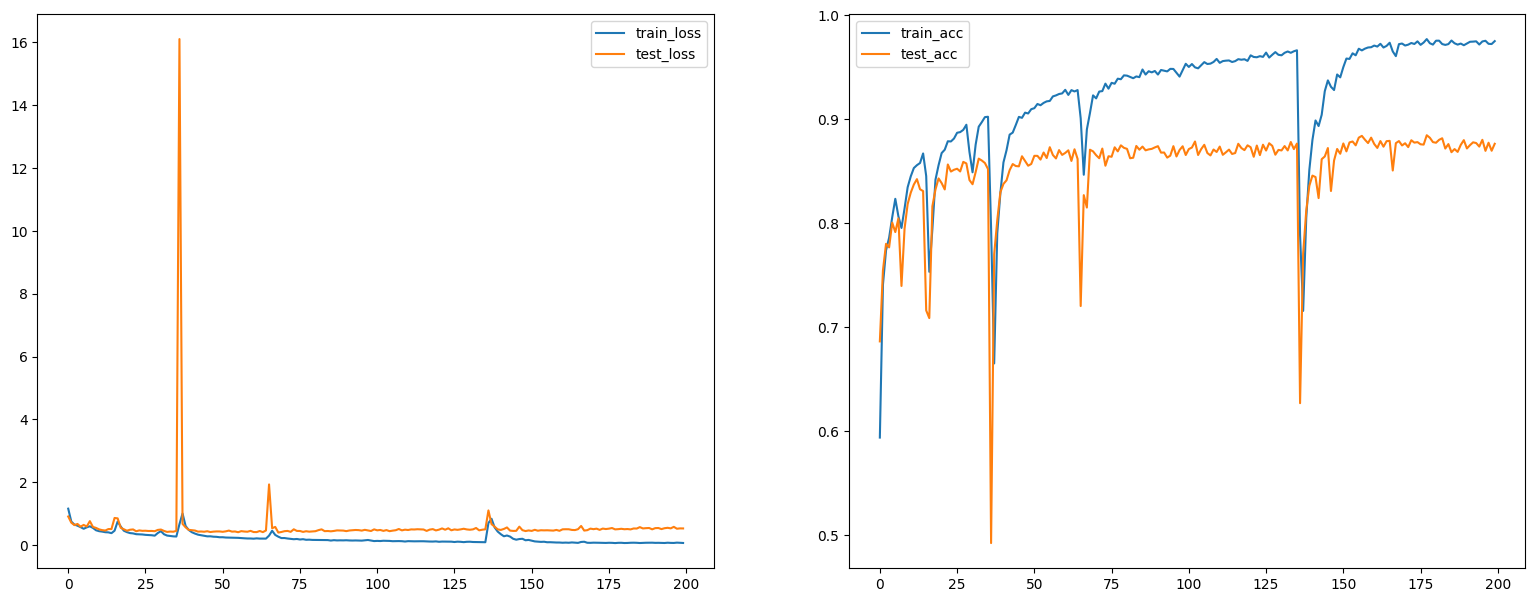

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)